In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.optimize import curve_fit
from copy import deepcopy
import matplotlib
%matplotlib inline

確率密度分布の推移を求める
状態名と遷移過程と半減期をインプット
分解しかしないパターンを実装した
数密度に左右されるような過渡状態を持つ場合、別のコードが必要

In [2]:
state_numbers = {
    "A": 0, #   状態名:通し番号
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
}

states_graph = [
    ("A", "B", float("inf"), 1, True),# 遷移前の状態, 遷移後の状態, 遷移前の状態の寿命, 数密度何倍になるか,　遷移先の状態は光励起直後か
    ("B", "C", 2.5, 1, False),
    ("B", "D", 0.5, 1, False),
    ("D", "E", 0.5, 1, False),
]

bins = 10**4
before_lay_time_range = 1
after_lay_time_range = 9
lay_width_time_range = 0.25
time_range = before_lay_time_range + after_lay_time_range

In [3]:
lay_d = np.exp(-(np.arange(bins) - bins*0.1)**2/(bins*lay_width_time_range/time_range)**2)
lay_d /= np.sum(lay_d)

tl = [0.0]*len(state_numbers)
dp = [[0.0]*bins for _ in range(len(state_numbers))]

dp_index_graph = [[] for _ in range(len(state_numbers))]
lay_TFs = [False]*len(state_numbers)
for s1, s2, T, amp, lay_TF in states_graph:
    dp_index_graph[state_numbers[s1]].append((state_numbers[s2], T, amp))
    lay_TFs[state_numbers[s2]] = lay_TF
    if lay_TF:
        tl[state_numbers[s1]] = 1.0 # 初期密度が0ではない場合の値の代入。本当は、光への感度に比例した値を入れる必要がある


for t in range(bins):
    for i in range(len(dp_index_graph)):#   遷移元ループ
        for j, T, amp in dp_index_graph[i]:#    遷移先ループ
            if lay_TFs[j]:  #   指定された遷移先が光励起直後だった場合(指定された遷移元が入射前の定常状態だった場合)
                tl[i] -= lay_d[t]
                tl[j] += amp*lay_d[t]
            else:
                delta = tl[i] * (1.0 - np.exp(-(time_range/bins)/T))
                tl[i] -= delta
                tl[j] += amp*delta

            dp[i][t] = tl[i]
            dp[j][t] = tl[j]

0.0022567583513024977 0.9999999999999999


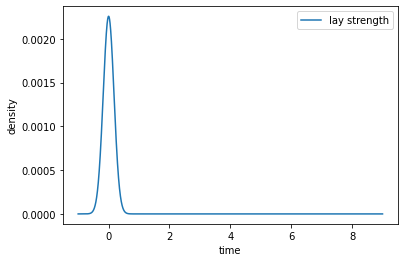

In [4]:
print(np.max(lay_d), np.sum(lay_d))
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
plt.plot(t, lay_d, label="lay strength")
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.savefig("result.png")

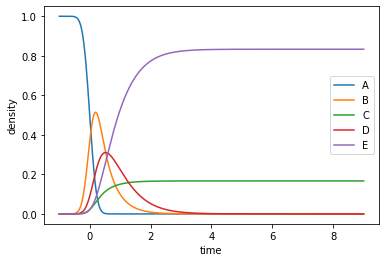

In [5]:
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
for state in state_numbers:
    plt.plot(t, dp[state_numbers[state]], label=state)
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.savefig("result.png")

In [11]:
#　各過渡状態が持つ吸光度を導入し、すべての状態のミックスの吸光度の時間変化を計算する
absorbance_dic = {
    "A":None,
    "B":None,
    "C":None,
    "D":None,
    "E":None
}
def gaussian_arr_creator(mean, std, max_density=1, ramda_lst=[i for i in range(200, 1000)]):
    ramda_arr = np.array(ramda_lst)
    return ramda_arr, max_density*np.exp(-(ramda_arr - mean)**2/std**2)

ramda_arr, A_arr = gaussian_arr_creator(mean=350, std=10, max_density=0.2)
ramda_arr, B_arr = gaussian_arr_creator(mean=700, std=10, max_density=1.0)
ramda_arr, C_arr = gaussian_arr_creator(mean=600, std=10, max_density=0.5)
ramda_arr, D_arr = gaussian_arr_creator(mean=400, std=10, max_density=0.2)
ramda_arr, E_arr = gaussian_arr_creator(mean=300, std=10, max_density=0.1)
absorbance_dic["A"] = A_arr
absorbance_dic["B"] = B_arr
absorbance_dic["C"] = C_arr
absorbance_dic["D"] = D_arr
absorbance_dic["E"] = E_arr

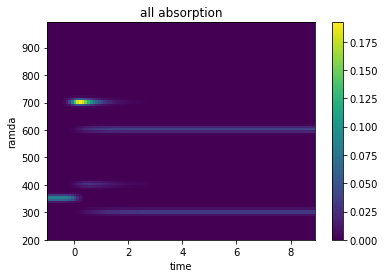

In [12]:
X, Y = 100, 100 #   X,Y軸のグリッド数
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
t_grid, ramda_grid = np.meshgrid(t[::max(1, len(t)//X)], ramda_arr[::max(1, len(ramda_arr)//Y)])

exist_colorbar = False
abs_sum_arr = None
for name in state_numbers:
    if name in absorbance_dic:
        abs_arr = np.outer(absorbance_dic[name][::max(1, len(ramda_arr)//X)], dp[state_numbers[name]][::max(1, len(t)//Y)])

        #plt.pcolor(abs_arr)
        plt.pcolor(t_grid, ramda_grid, abs_arr[:-1,:-1])
        plt.xlabel("time")
        plt.ylabel("ramda")
        plt.title(name)
        if not exist_colorbar:
            plt.colorbar()
            exist_colorbar = True
        plt.savefig("absorption"+name+".png")
        if abs_sum_arr is None:
            abs_sum_arr = abs_arr
        else:
            abs_sum_arr += abs_arr
        

plt.pcolor(t_grid, ramda_grid, abs_sum_arr[:-1,:-1])
plt.xlabel("time")
plt.ylabel("ramda")
plt.title("all absorption")
plt.savefig("all absorption.png")

フィッティングには　SciPyのcurve_fitでうまくいかなかったので、MCMCでパラメータの確率分布を求めるバージョンを試す
MCMC用の仮想環境をローカルに作って、適用する

Abs{λ)=Σ_t=1^100 absorption(λ, t) でピークの波長と幅を決める
scipy でAbs{λ)をフィッティング、ピーク位置とピーク強度パラメータと幅パラメータを得る

各ピーク強度の時間変化を決める。
ピーク位置パラメータと幅パラメータを既知の値として使いつつ、フィッティングしてピーク強度パラメータを出力する

ピーク強度の時間変化(規格化済み)の内積を取り、
内積が大きい組み合わせから「指定された過渡状態の数」になるまで同期している組み合わせを統合する

各過渡状態の遷移グラフと時間数密度分布(正規化)を計算

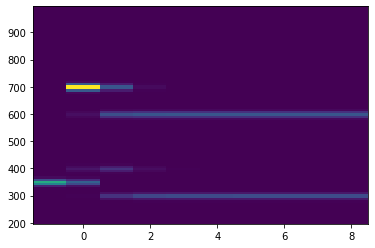

In [13]:
observed_t = t[::len(t)//10]
observed_ramda = ramda_arr[::len(ramda_arr)//100]
observed_t_grid, observed_ramda_grid = np.meshgrid(observed_t, observed_ramda)
observed_absorption = deepcopy(abs_sum_arr[::max(1, len(abs_sum_arr[0])//len(observed_ramda)), ::max(1, len(abs_sum_arr[0])//len(observed_t))])

plt.pcolor(observed_t_grid, observed_ramda_grid, observed_absorption)

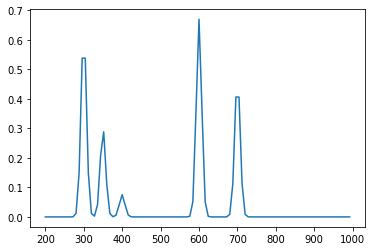

In [14]:
absorption_distribution = np.sum(observed_absorption, axis=1)
plt.plot(observed_ramda, absorption_distribution)

In [10]:
import pymc3 as pm

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable C:\Program
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
with pm.Model() as gaussian_fitting_model:
    waidth300 = pm.Normal("noise", mu=300, sigma=10)
    waidth350 = pm.Normal("noise", mu=350, sigma=10)
    waidth400 = pm.Normal("noise", mu=400, sigma=10)
    waidth600 = pm.Normal("noise", mu=600, sigma=10)
    waidth700 = pm.Normal("noise", mu=700, sigma=10)
    
    